# Mount From Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os
data_dir = "/content/gdrive/My Drive/FER2013"
model_dir = "/content/gdrive/My Drive/ModelWeights/resnet50.h5"

# Import Libraries and Utilities

In [ ]:
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, losses
from keras.layers import *
from keras.models import Model, Sequential
from keras.preprocessing import image
import numpy as np
from glob import glob
from tensorflow.keras.callbacks import EarlyStopping
import keras
from keras.optimizers import Adam
from tensorflow.keras.layers.experimental import preprocessing

keras.__version__

'2.12.0'

# Import Train/Test Data

In [ ]:
train_path = data_dir + '/train'
valid_path = data_dir + '/test'

train_generator = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(train_path, target_size=(224, 224), batch_size=32)
valid_generator = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(valid_path, target_size=(224, 224), batch_size=32)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Define Model

In [ ]:
base = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

for layer in base.layers[:-11]:
  layer.trainable = False

x = base.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

# Compile & Fit Model

In [ ]:
epochs_ = 20
optimizer_ = Adam(learning_rate=0.0001, epsilon=0.01)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='categorical_crossentropy', optimizer=optimizer_, metrics=['accuracy'])
model.fit(train_generator, validation_data=valid_generator, epochs=epochs_, callbacks=[early_stopping])


Epoch 1/20
898/898 [==============================] - 142s 152ms/step - loss: 2.1370 - accuracy: 0.2765 - val_loss: 1.4626 - val_accuracy: 0.4660
Epoch 2/20
898/898 [==============================] - 136s 151ms/step - loss: 1.6531 - accuracy: 0.4184 - val_loss: 1.3053 - val_accuracy: 0.5039
Epoch 3/20
898/898 [==============================] - 136s 152ms/step - loss: 1.4523 - accuracy: 0.4716 - val_loss: 1.2322 - val_accuracy: 0.5382
Epoch 4/20
898/898 [==============================] - 136s 151ms/step - loss: 1.3383 - accuracy: 0.5076 - val_loss: 1.2011 - val_accuracy: 0.5566
Epoch 5/20
898/898 [==============================] - 135s 150ms/step - loss: 1.2484 - accuracy: 0.5388 - val_loss: 1.1649 - val_accuracy: 0.5655
Epoch 6/20
898/898 [==============================] - 137s 152ms/step - loss: 1.1732 - accuracy: 0.5660 - val_loss: 1.1449 - val_accuracy: 0.5701
Epoch 7/20
898/898 [==============================] - 136s 151ms/step - loss: 1.1102 - accuracy: 0.5866 - val_loss: 1.1521 -

# Save the Model

In [ ]:
model.save('/content/gdrive/My Drive/ModelWeights/resnet50.h5')

# Load the Model and Evaluate

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model('/content/gdrive/My Drive/ModelWeights/resnet50.h5')

In [ ]:
eval_path = "/content/gdrive/My Drive/FER2013/test"

eval_generator = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(eval_path, target_size=(224, 224), batch_size=16)

Found 7178 images belonging to 7 classes.


In [ ]:
import numpy as np
import random
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing import image

img_files = eval_generator.filenames
img_labels = eval_generator.labels

def load_image_for_model(img_path):
  img = image.load_img(img_path, target_size=(224, 224))
  img = image.img_to_array(img)
  img = np.reshape(img, (1, 224, 224, 3))
  img = preprocess_input(img)
  return img

In [ ]:
def accuracy_calc(img_files, img_labels, eval_path, loaded_model):
  eval_subset = []
  eval_labels = []
  lbl_pred = []
  index = random.sample(range(len(img_files)), 100)
  for i in index:
    img_loaded = load_image_for_model(eval_path + '/' + img_files[i])
    eval_subset.append(img_loaded)
    eval_labels.append(img_labels[i])
  for eval_sub in eval_subset:
    lbl_predictions = loaded_model.predict(eval_sub, verbose=False)
    for lbl in lbl_predictions:
      max_idx = np.argmax(lbl)
      lbl_pred.append(max_idx)
  lbl_true = eval_labels
  acc = accuracy_score(lbl_true, lbl_pred)
  return acc

In [ ]:
accuracies = []

for _ in range(10):
  acc= accuracy_calc(img_files, img_labels, eval_path, loaded_model)
  accuracies.append(acc)

Text(0.5, 1.0, 'ResNet50 Evaluation')

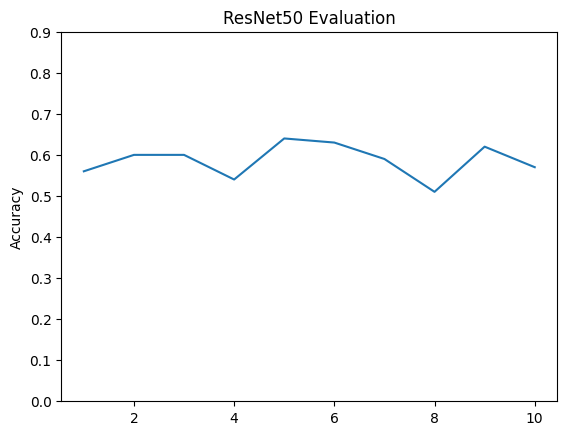

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.array(range(len(top1_accuracies)))+1, top1_accuracies)
plt.ylabel('Accuracy')
plt.yticks(np.arange(0,1,0.1))
plt.title('ResNet50 Evaluation')

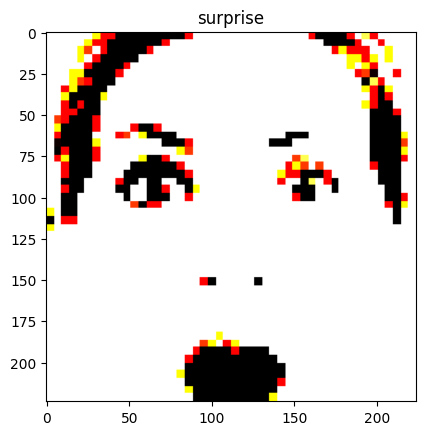

In [ ]:
img_test = []
img_test_lbl = []
emotion_dict = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "neutral", 5: "sad", 6: "surprise"}

ix = random.sample(range(len(img_files)), 10)
for i in ix:
    img_test_loaded = load_image_for_model(eval_path + '/' + img_files[i])
    img_test.append(img_test_loaded)
    img_test_lbl.append(img_labels[i])

img_test = np.array(img_test)

for _ in range(len(img_test)):
  im = np.reshape(img_test[_], (224, 224, 3))
  plt.imshow(im)
  plt.title(emotion_dict[img_test_lbl[_]])